In [3]:
# --- Cell 1: Setup and Imports (Corrected) ---

print("Importing libraries...")
import os
import numpy as np
import pickle
from tqdm import tqdm
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Suppress TensorFlow informational messages for a cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# !!! THIS IS THE CORRECTED LINE !!!
# We import tensorflow and give it the standard alias 'tf'
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

print("--> Libraries imported successfully.")

Importing libraries...
--> Libraries imported successfully.


In [5]:
# --- Cell 2: Define Paths and Load Core Models (Corrected) ---

print("Defining file paths and loading models...")

# 1. Define File Paths
BASE_PATH = '/kaggle/input/clothestry/clothes_tryon_dataset/'
CLOTH_DATABASE_PATH = os.path.join(BASE_PATH, 'train', 'cloth')
QUERY_IMAGE_PATH_DIR = os.path.join(BASE_PATH, 'train', 'image')
OUTPUT_PATH = '/kaggle/working/'

# 2. Load TFLite Segmentation Model
try:
    # NOTE: I'm updating the path based on your error log.
    tflite_model_path = '/kaggle/input/deeplabv3-xception65/tflite/ade20k/2/2.tflite'
    
    segmentation_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    segmentation_interpreter.allocate_tensors()
    
    segmentation_input_details = segmentation_interpreter.get_input_details()
    segmentation_output_details = segmentation_interpreter.get_output_details()

    print(f"--> TFLite Segmentation model loaded successfully from: {tflite_model_path}")
    print(f"    Input Shape: {segmentation_input_details[0]['shape']}")

except Exception as e:
    print(f"!!! FATAL ERROR loading TFLite segmentation model: {e}")
    raise 

# 3. Load Feature Extraction Model (ResNet50)
try:
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    # !!! THIS IS THE CORRECTED LINE !!!
    # Use 'tf.keras.Sequential' instead of 'tensorflow.keras.Sequential'
    model_feature_extractor = tf.keras.Sequential([base_model, GlobalMaxPooling2D()])
    
    print("--> Feature extraction model (ResNet50) created.")
except Exception as e:
    print(f"!!! FATAL ERROR creating feature extraction model: {e}")
    raise

Defining file paths and loading models...
--> TFLite Segmentation model loaded successfully from: /kaggle/input/deeplabv3-xception65/tflite/ade20k/2/2.tflite
    Input Shape: [  1 513 513   3]
--> Feature extraction model (ResNet50) created.


In [ ]:
# --- Cell 3: Define Helper Functions (Corrected with new Class ID) ---

print("Defining helper functions...")

# This function uses the ResNet50 model and does not need changes.
def extract_features(img_pil, model):
    # ... (function content is unchanged) ...
    try:
        img_resized = img_pil.resize((224, 224))
        img_array = np.array(img_resized)
        expand_img = np.expand_dims(img_array, axis=0)
        pre_img = preprocess_input(expand_img)
        result = model.predict(pre_img, verbose=0).flatten()
        return result / norm(result)
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return None

# This function is modified with the correct class ID.
def segment_and_crop_garment(image_path, interpreter, input_details, output_details):
    """Takes an image path, detects clothing using a TFLite interpreter, and returns a cropped PIL Image."""
    # ... (the beginning of the function is unchanged) ...
    try:
        original_image_pil = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return None
        
    original_image_np = np.array(original_image_pil)
    _, input_height, input_width, _ = input_details[0]['shape']
    resized_image = cv2.resize(original_image_np, (input_width, input_height))
    input_data = np.expand_dims(resized_image, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    segmentation_mask = interpreter.get_tensor(output_details[0]['index'])[0]
    segmentation_mask = np.argmax(segmentation_mask, axis=-1)
    
    
    top_classes = [13] 
    
    binary_mask = np.zeros_like(segmentation_mask, dtype=bool)
    for class_id in top_classes:
        binary_mask = binary_mask | (segmentation_mask == class_id)
        
    mask_resized_pil = Image.fromarray(binary_mask.astype(np.uint8) * 255)
    mask_resized_pil = mask_resized_pil.resize(original_image_pil.size, Image.NEAREST)
    mask_resized = np.array(mask_resized_pil).astype(bool)
    
    if not np.any(mask_resized): return None

    where = np.where(mask_resized)
    (ymin, ymax), (xmin, xmax) = (np.min(where[0]), np.max(where[0])), (np.min(where[1]), np.max(where[1]))
    
    padding = 15
    cropped_image = original_image_pil.crop((
        max(0, xmin - padding), max(0, ymin - padding),
        min(original_image_np.shape[1], xmax + padding), min(original_image_np.shape[0], ymax + padding)
    ))
    return cropped_image

print("--> Helper functions updated with correct class ID [13].")

Defining helper functions...
--> Helper functions updated with correct class ID [13].


In [ ]:

feature_list_path = os.path.join(OUTPUT_PATH, 'embedding.pkl')
filenames_path = os.path.join(OUTPUT_PATH, 'filenames.pkl')

if not os.path.exists(feature_list_path) or not os.path.exists(filenames_path):
    print("Feature database not found. Creating a new one...")
    print("(This is a one-time process and may take 15-30 minutes.)")
    
    cloth_filenames = [os.path.join(CLOTH_DATABASE_PATH, f) for f in sorted(os.listdir(CLOTH_DATABASE_PATH))]
    feature_list = []

    # The tqdm wrapper provides a nice progress bar
    for filename in tqdm(cloth_filenames, desc="Extracting Features"):
        try:
            img_pil = Image.open(filename).convert("RGB")
            features = extract_features(img_pil, model_feature_extractor)
            if features is not None:
                feature_list.append(features)
        except Exception as e:
            print(f"Skipping file {filename} due to error: {e}")
    
    # Save the generated database to disk
    with open(feature_list_path, 'wb') as f:
        pickle.dump(feature_list, f)
    with open(filenames_path, 'wb') as f:
        pickle.dump(cloth_filenames, f)
        
    print(f"--> Database created and saved successfully to '{OUTPUT_PATH}'")
else:
    print(f"--> Found existing feature database in '{OUTPUT_PATH}'. Skipping creation.")

Feature database not found. Creating a new one...
(This is a one-time process and may take 15-30 minutes.)


Extracting Features:   0%|          | 0/11647 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1752909935.831674     100 service.cc:148] XLA service 0x7a803c048ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752909935.832555     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752909935.832577     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752909936.472118     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752909939.090939     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting Features: 100%|██████████| 11647/11647 [21:35<00:00,  8.99it/s]


--> Database created and saved successfully to '/kaggle/working/'


--- Starting Segmentation Debugging ---
Analyzing image: /kaggle/input/clothestry/clothes_tryon_dataset/train/image/00001_00.jpg

Unique class IDs detected in the image: [  1   2   3   4   5   6   8   9  10  11  13  15  16  18  23  31  37  39
  40  42  53  54  55  60  65  67  68  69  70  78  82  83  86  88  91  94
  95  96  98  99 109 111 112 113 120 127 128 132 133 135 140 148 149]
The class ID at the center of the image is: 13


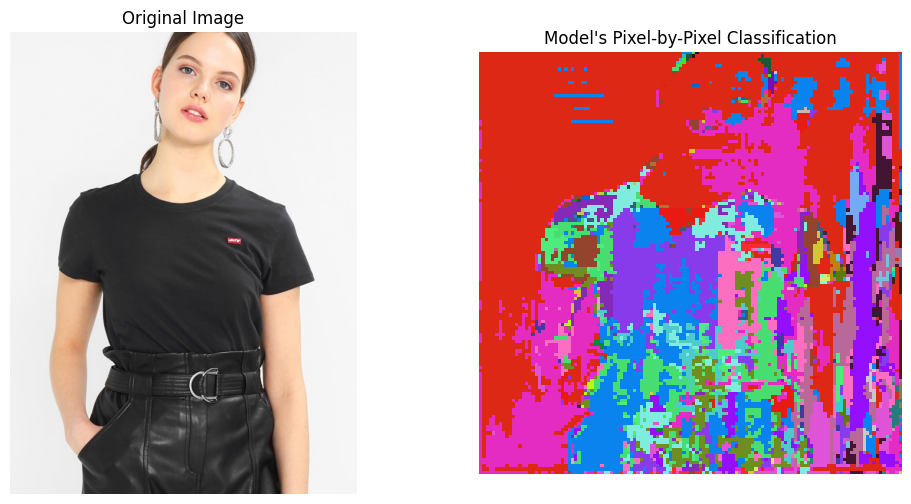


--> Compare the colored segmentation map to the original image.
--> Identify the color covering the clothing and find its corresponding ID in the 'Unique class IDs' list above.


In [ ]:

print("--- Starting Segmentation Debugging ---")

debug_image_filename = '00001_00.jpg' 
debug_image_path = os.path.join(QUERY_IMAGE_PATH_DIR, debug_image_filename)
print(f"Analyzing image: {debug_image_path}")

original_image_pil = Image.open(debug_image_path).convert("RGB")
original_image_np = np.array(original_image_pil)
_, input_height, input_width, _ = segmentation_input_details[0]['shape']
resized_image = cv2.resize(original_image_np, (input_width, input_height))
input_data = np.expand_dims(resized_image, axis=0).astype(np.float32)

segmentation_interpreter.set_tensor(segmentation_input_details[0]['index'], input_data)
segmentation_interpreter.invoke()
full_mask_output = segmentation_interpreter.get_tensor(segmentation_output_details[0]['index'])[0]
pixel_class_map = np.argmax(full_mask_output, axis=-1)

# --- Find the unique class IDs the model detected in the image ---
unique_classes_found = np.unique(pixel_class_map)
print(f"\nUnique class IDs detected in the image: {unique_classes_found}")

# Let's find the class ID for the center of the image, which is likely part of the person/clothing
center_y, center_x = pixel_class_map.shape[0] // 2, pixel_class_map.shape[1] // 2
center_class_id = pixel_class_map[center_y, center_x]
print(f"The class ID at the center of the image is: {center_class_id}")


ade20k_colormap = np.zeros((256, 3), dtype=np.uint8)
for i in range(256):
    ade20k_colormap[i] = [np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)]
ade20k_colormap[0] = [0, 0, 0] 

color_segmentation_map = ade20k_colormap[pixel_class_map]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image_pil)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(color_segmentation_map)
axes[1].set_title("Model's Pixel-by-Pixel Classification")
axes[1].axis('off')

plt.show()

print("\n--> Compare the colored segmentation map to the original image.")
print("--> Identify the color covering the clothing and find its corresponding ID in the 'Unique class IDs' list above.")

Loading feature database for recommendation...
--> Database with 11647 embeddings loaded.
--> Recommender is ready.

--- Running recommendation for: 00001_00.jpg ---
1. Garment detected and cropped.
2. Features extracted from cropped garment.
3. Found 5 most similar items.


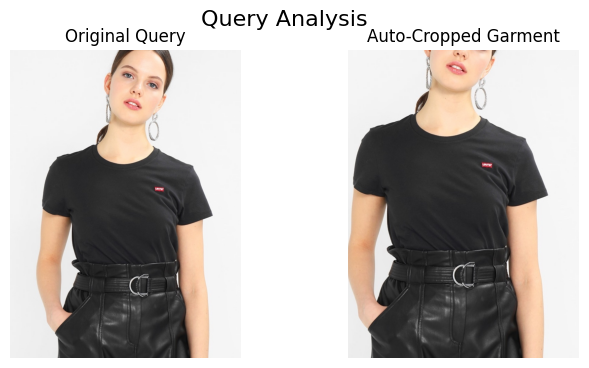


--- TOP 5 RECOMMENDATIONS ---


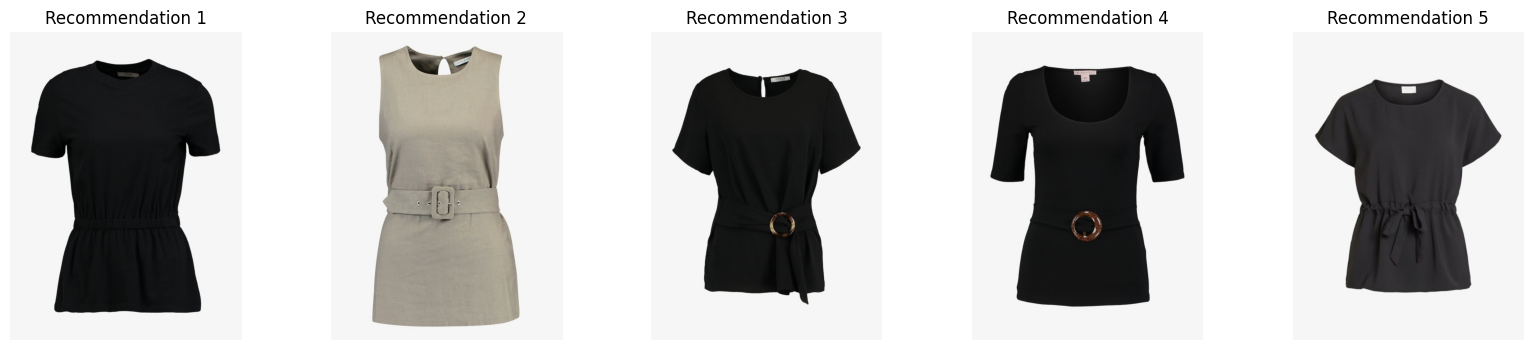


--- SCRIPT FINISHED ---


In [ ]:

print("Loading feature database for recommendation...")
# This part is unchanged
feature_list_path = os.path.join(OUTPUT_PATH, 'embedding.pkl')
filenames_path = os.path.join(OUTPUT_PATH, 'filenames.pkl')

try:
    feature_list = np.array(pickle.load(open(feature_list_path, 'rb')))
    filenames = pickle.load(open(filenames_path, 'rb'))
    print(f"--> Database with {len(feature_list)} embeddings loaded.")
except Exception as e:
    print(f"!!! FATAL ERROR loading database files: {e}")
    raise

# This part is unchanged
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')
neighbors.fit(feature_list)
print("--> Recommender is ready.")

# This part is unchanged
query_image_filename = '00001_00.jpg' 
query_image_path = os.path.join(QUERY_IMAGE_PATH_DIR, query_image_filename)

print(f"\n--- Running recommendation for: {query_image_filename} ---")


cropped_garment = segment_and_crop_garment(
    query_image_path, 
    segmentation_interpreter, 
    segmentation_input_details, 
    segmentation_output_details
)

# The rest of the pipeline is unchanged
if cropped_garment:
    print("1. Garment detected and cropped.")
    query_features = extract_features(cropped_garment, model_feature_extractor)
    
    if query_features is not None:
        print("2. Features extracted from cropped garment.")
        distances, indices = neighbors.kneighbors([query_features])
        print("3. Found 5 most similar items.")
        
        # Display Results
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(Image.open(query_image_path)); axes[0].set_title("Original Query"); axes[0].axis('off')
        axes[1].imshow(cropped_garment); axes[1].set_title("Auto-Cropped Garment"); axes[1].axis('off')
        plt.suptitle("Query Analysis", fontsize=16); plt.show()
        
        print("\n--- TOP 5 RECOMMENDATIONS ---")
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        for i, file_index in enumerate(indices[0]):
            ax = axes[i]
            recommended_image_path = filenames[file_index]
            ax.imshow(Image.open(recommended_image_path)); ax.set_title(f"Recommendation {i+1}"); ax.axis('off')
        plt.show()
    else:
        print("!!! FAILED: Could not extract features from the cropped garment.")
else:
    print("\n!!! FAILED: Could not detect a garment in the query image.")
    plt.imshow(Image.open(query_image_path)); plt.title("Original Query (Detection Failed)"); plt.axis('off'); plt.show()

print("\n--- SCRIPT FINISHED ---")

Loading feature database for recommendation...
--> Database with 11647 embeddings loaded.
--> Recommender is ready.

--- Running recommendation for: 00001_00.jpg ---
1. Garment detected and cropped.
2. Features extracted from cropped garment.
3. Found 5 most similar items.


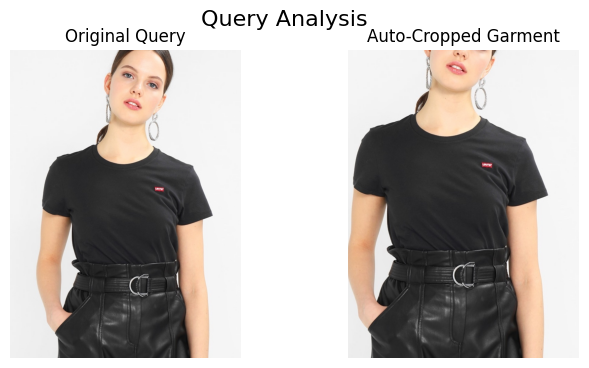


--- TOP 5 RECOMMENDATIONS (with scores) ---
  Rank 1: Similarity = 0.5716, File Code = 06951_00.jpg
  Rank 2: Similarity = 0.5677, File Code = 08870_00.jpg
  Rank 3: Similarity = 0.5607, File Code = 10893_00.jpg
  Rank 4: Similarity = 0.5588, File Code = 08533_00.jpg
  Rank 5: Similarity = 0.5588, File Code = 09609_00.jpg


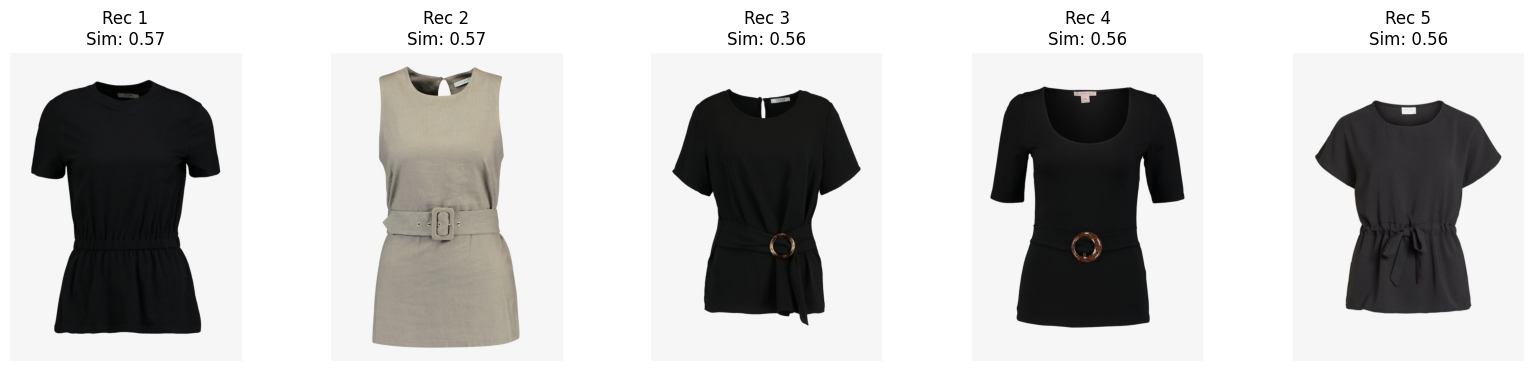


--- SCRIPT FINISHED ---


In [ ]:

print("Loading feature database for recommendation...")
feature_list_path = os.path.join(OUTPUT_PATH, 'embedding.pkl')
filenames_path = os.path.join(OUTPUT_PATH, 'filenames.pkl')

try:
    feature_list = np.array(pickle.load(open(feature_list_path, 'rb')))
    filenames = pickle.load(open(filenames_path, 'rb'))
    print(f"--> Database with {len(feature_list)} embeddings loaded.")
except Exception as e:
    print(f"!!! FATAL ERROR loading database files: {e}")
    raise

neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')
neighbors.fit(feature_list)
print("--> Recommender is ready.")

query_image_filename = '00001_00.jpg' 
query_image_path = os.path.join(QUERY_IMAGE_PATH_DIR, query_image_filename)

print(f"\n--- Running recommendation for: {query_image_filename} ---")

cropped_garment = segment_and_crop_garment(
    query_image_path, 
    segmentation_interpreter, 
    segmentation_input_details, 
    segmentation_output_details
)

if cropped_garment:
    print("1. Garment detected and cropped.")
    query_features = extract_features(cropped_garment, model_feature_extractor)
    
    if query_features is not None:
        print("2. Features extracted from cropped garment.")
        
        # --- GET DISTANCES AND INDICES ---
        distances, indices = neighbors.kneighbors([query_features])
        print("3. Found 5 most similar items.")
        
        # --- Display the Query Analysis ---
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(Image.open(query_image_path)); axes[0].set_title("Original Query"); axes[0].axis('off')
        axes[1].imshow(cropped_garment); axes[1].set_title("Auto-Cropped Garment"); axes[1].axis('off')
        plt.suptitle("Query Analysis", fontsize=16); plt.show()

        print("\n--- TOP 5 RECOMMENDATIONS (with scores) ---")
        for i in range(len(indices[0])):
            rank = i + 1
            # The 'indices' array gives us the position in our database
            file_index = indices[0][i]
            # The 'distances' array gives the Euclidean distance
            distance = distances[0][i]
            
            
            similarity_score = 1 / (1 + distance)
            
            
            file_code = os.path.basename(filenames[file_index])
            
            print(f"  Rank {rank}: Similarity = {similarity_score:.4f}, File Code = {file_code}")

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        for i, file_index in enumerate(indices[0]):
            ax = axes[i]
            recommended_image_path = filenames[file_index]
            ax.imshow(Image.open(recommended_image_path))
            
            
            similarity = 1 / (1 + distances[0][i])
            ax.set_title(f"Rec {i+1}\nSim: {similarity:.2f}")
            ax.axis('off')
        plt.show()

    else:
        print("!!! FAILED: Could not extract features from the cropped garment.")
else:
    print("\n!!! FAILED: Could not detect a garment in the query image.")
    plt.imshow(Image.open(query_image_path)); plt.title("Original Query (Detection Failed)"); plt.axis('off'); plt.show()

print("\n--- SCRIPT FINISHED ---")

Loading feature database for recommendation...
--> Database with 11647 embeddings loaded.
--> Euclidean Recommender is ready.
--> Cosine Recommender is ready.

--- Running recommendation for: 00001_00.jpg ---
1. Garment detected and cropped.
2. Features extracted from cropped garment.


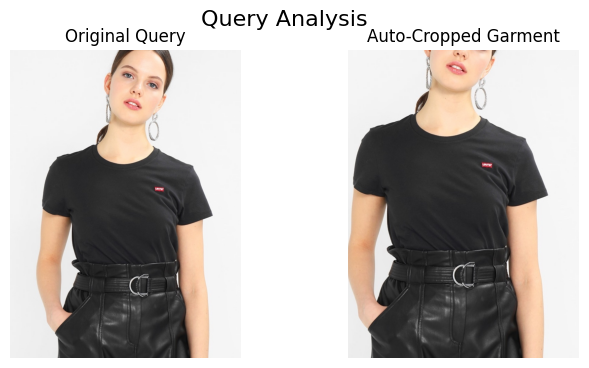


      RESULTS USING EUCLIDEAN DISTANCE
--> Lower distance is better.
  Rank 1: Euclidean Distance = 0.7495, File Code = 06951_00.jpg
  Rank 2: Euclidean Distance = 0.7613, File Code = 08870_00.jpg
  Rank 3: Euclidean Distance = 0.7835, File Code = 10893_00.jpg
  Rank 4: Euclidean Distance = 0.7895, File Code = 08533_00.jpg
  Rank 5: Euclidean Distance = 0.7896, File Code = 09609_00.jpg


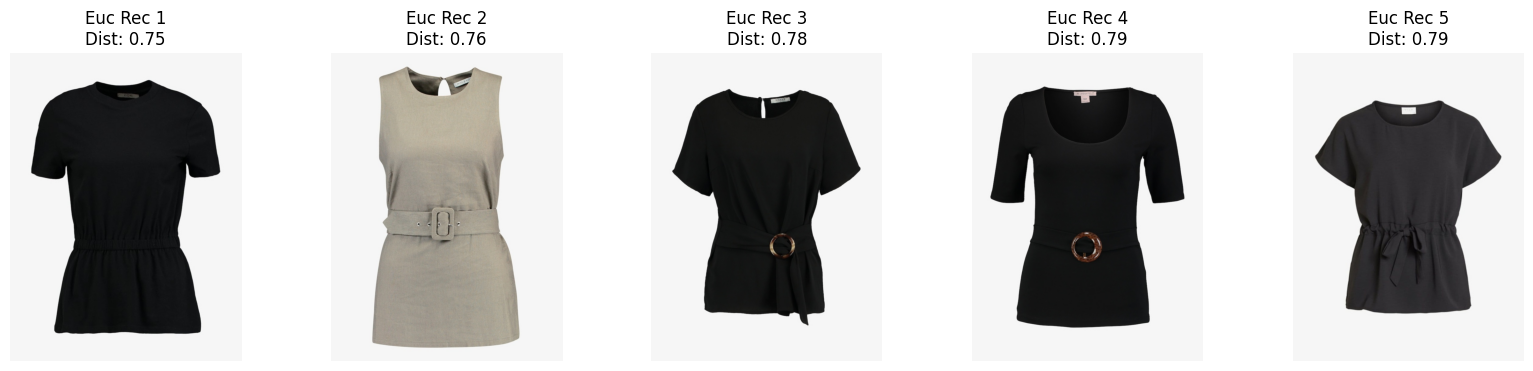


        RESULTS USING COSINE SIMILARITY
--> Higher similarity is better.
  Rank 1: Cosine Similarity = 0.7192, File Code = 06951_00.jpg
  Rank 2: Cosine Similarity = 0.7102, File Code = 08870_00.jpg
  Rank 3: Cosine Similarity = 0.6930, File Code = 10893_00.jpg
  Rank 4: Cosine Similarity = 0.6883, File Code = 08533_00.jpg
  Rank 5: Cosine Similarity = 0.6883, File Code = 09609_00.jpg


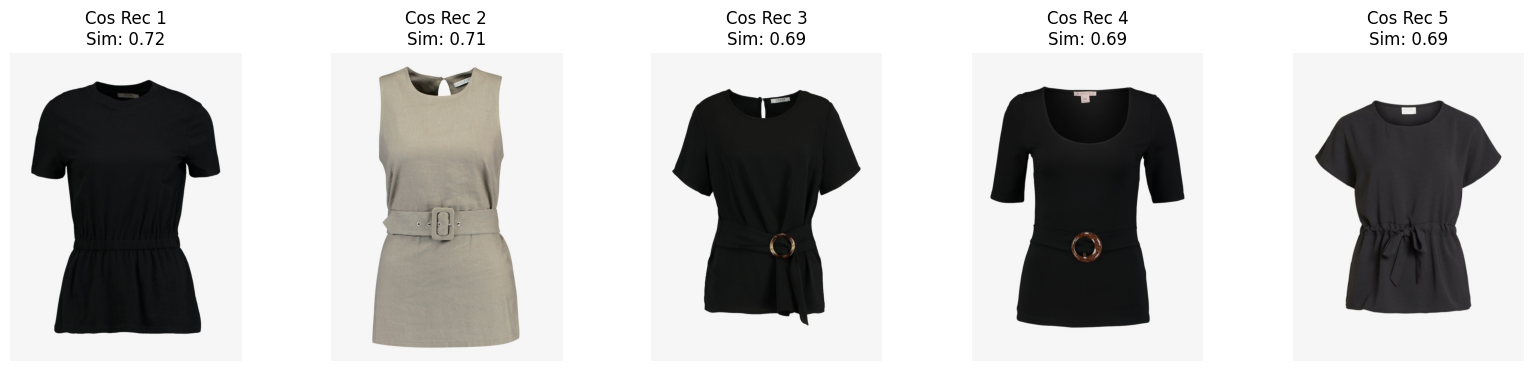


--- SCRIPT FINISHED ---


In [ ]:
# --- Cell 5: Load Database and Run Recommendation Pipeline (with Multiple Metrics) ---

print("Loading feature database for recommendation...")
# Load the pre-computed feature database
feature_list_path = os.path.join(OUTPUT_PATH, 'embedding.pkl')
filenames_path = os.path.join(OUTPUT_PATH, 'filenames.pkl')

try:
    feature_list = np.array(pickle.load(open(feature_list_path, 'rb')))
    filenames = pickle.load(open(filenames_path, 'rb'))
    print(f"--> Database with {len(feature_list)} embeddings loaded.")
except Exception as e:
    print(f"!!! FATAL ERROR loading database files: {e}")
    raise


neighbors_euclidean = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')
neighbors_euclidean.fit(feature_list)
print("--> Euclidean Recommender is ready.")


neighbors_cosine = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine')
neighbors_cosine.fit(feature_list)
print("--> Cosine Recommender is ready.")


# --- Select a Query Image to Test ---
query_image_filename = '00001_00.jpg' 
query_image_path = os.path.join(QUERY_IMAGE_PATH_DIR, query_image_filename)
print(f"\n--- Running recommendation for: {query_image_filename} ---")

# --- Run the Pipeline ---
cropped_garment = segment_and_crop_garment(
    query_image_path, 
    segmentation_interpreter, 
    segmentation_input_details, 
    segmentation_output_details
)

if cropped_garment:
    print("1. Garment detected and cropped.")
    query_features = extract_features(cropped_garment, model_feature_extractor)
    
    if query_features is not None:
        print("2. Features extracted from cropped garment.")
        
        # --- Display the Query Analysis ---
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(Image.open(query_image_path)); axes[0].set_title("Original Query"); axes[0].axis('off')
        axes[1].imshow(cropped_garment); axes[1].set_title("Auto-Cropped Garment"); axes[1].axis('off')
        plt.suptitle("Query Analysis", fontsize=16); plt.show()
        
        distances_euc, indices_euc = neighbors_euclidean.kneighbors([query_features])
        print("\n" + "="*50)
        print("      RESULTS USING EUCLIDEAN DISTANCE")
        print("="*50)
        print("--> Lower distance is better.")
        for i in range(len(indices_euc[0])):
            rank = i + 1
            file_index = indices_euc[0][i]
            distance = distances_euc[0][i]
            file_code = os.path.basename(filenames[file_index])
            print(f"  Rank {rank}: Euclidean Distance = {distance:.4f}, File Code = {file_code}")
        
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        for i, file_index in enumerate(indices_euc[0]):
            ax = axes[i]; recommended_image_path = filenames[file_index]
            ax.imshow(Image.open(recommended_image_path))
            ax.set_title(f"Euc Rec {i+1}\nDist: {distances_euc[0][i]:.2f}"); ax.axis('off')
        plt.show()

        # --- B) GET AND DISPLAY COSINE RESULTS ---
        distances_cos, indices_cos = neighbors_cosine.kneighbors([query_features])
        print("\n" + "="*50)
        print("        RESULTS USING COSINE SIMILARITY")
        print("="*50)
        print("--> Higher similarity is better.")
        for i in range(len(indices_cos[0])):
            rank = i + 1
            file_index = indices_cos[0][i]
            # Convert cosine distance back to cosine similarity for intuition (Similarity = 1 - Distance)
            similarity = 1 - distances_cos[0][i]
            file_code = os.path.basename(filenames[file_index])
            print(f"  Rank {rank}: Cosine Similarity = {similarity:.4f}, File Code = {file_code}")
            
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        for i, file_index in enumerate(indices_cos[0]):
            ax = axes[i]; recommended_image_path = filenames[file_index]
            ax.imshow(Image.open(recommended_image_path))
            similarity = 1 - distances_cos[0][i]
            ax.set_title(f"Cos Rec {i+1}\nSim: {similarity:.2f}"); ax.axis('off')
        plt.show()

    else:
        print("!!! FAILED: Could not extract features from the cropped garment.")
else:
    print("\n!!! FAILED: Could not detect a garment in the query image.")
    plt.imshow(Image.open(query_image_path)); plt.title("Original Query (Detection Failed)"); plt.axis('off'); plt.show()

print("\n--- SCRIPT FINISHED ---")

Loading feature database for recommendation...
--> Database with 11647 embeddings loaded.
--> Euclidean Recommender is ready.
--> Cosine Recommender is ready.

--- Running recommendation for: 00001_00.jpg ---
1. Garment detected and cropped.
2. Features extracted from cropped garment.


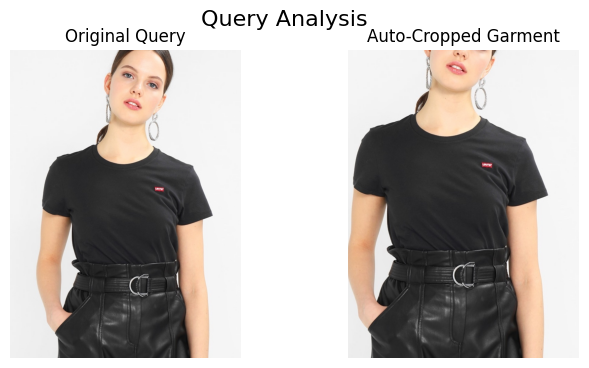


      RESULTS USING EUCLIDEAN DISTANCE (Top 10)
--> Lower distance is better.
  Rank 01: Euclidean Distance = 0.7495, File Code = 06951_00.jpg
  Rank 02: Euclidean Distance = 0.7613, File Code = 08870_00.jpg
  Rank 03: Euclidean Distance = 0.7835, File Code = 10893_00.jpg
  Rank 04: Euclidean Distance = 0.7895, File Code = 08533_00.jpg
  Rank 05: Euclidean Distance = 0.7896, File Code = 09609_00.jpg
  Rank 06: Euclidean Distance = 0.7915, File Code = 08597_00.jpg
  Rank 07: Euclidean Distance = 0.7942, File Code = 12579_00.jpg
  Rank 08: Euclidean Distance = 0.7978, File Code = 05118_00.jpg
  Rank 09: Euclidean Distance = 0.7982, File Code = 13543_00.jpg
  Rank 10: Euclidean Distance = 0.7995, File Code = 05337_00.jpg


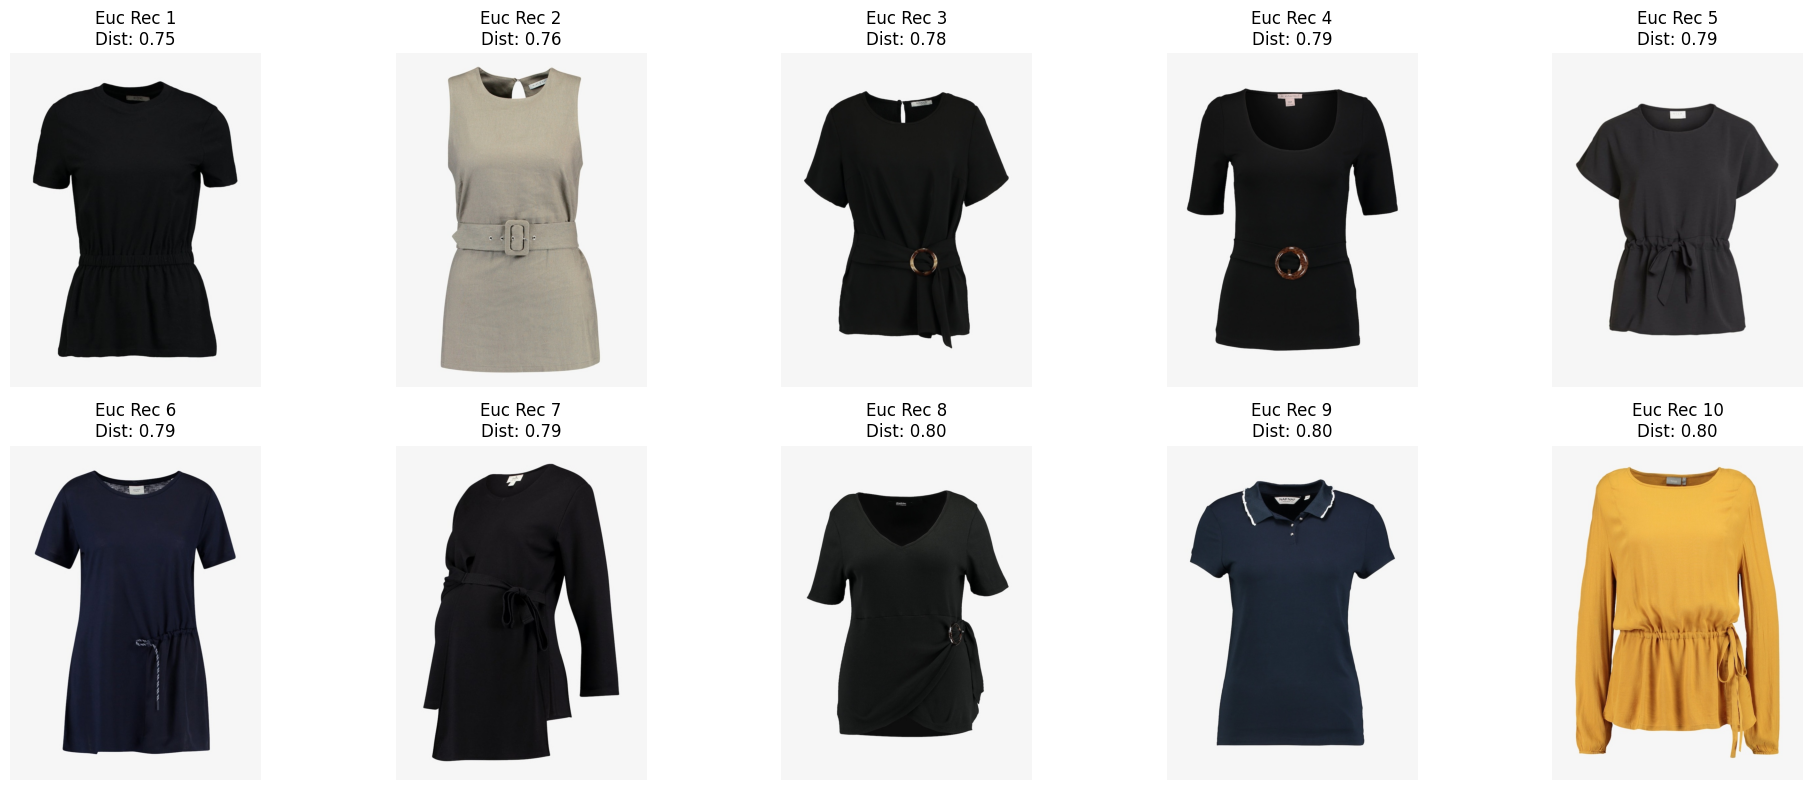


        RESULTS USING COSINE SIMILARITY (Top 10)
--> Higher similarity is better.
  Rank 01: Cosine Similarity = 0.7192, File Code = 06951_00.jpg
  Rank 02: Cosine Similarity = 0.7102, File Code = 08870_00.jpg
  Rank 03: Cosine Similarity = 0.6930, File Code = 10893_00.jpg
  Rank 04: Cosine Similarity = 0.6883, File Code = 08533_00.jpg
  Rank 05: Cosine Similarity = 0.6883, File Code = 09609_00.jpg
  Rank 06: Cosine Similarity = 0.6868, File Code = 08597_00.jpg
  Rank 07: Cosine Similarity = 0.6847, File Code = 12579_00.jpg
  Rank 08: Cosine Similarity = 0.6818, File Code = 05118_00.jpg
  Rank 09: Cosine Similarity = 0.6815, File Code = 13543_00.jpg
  Rank 10: Cosine Similarity = 0.6804, File Code = 05337_00.jpg


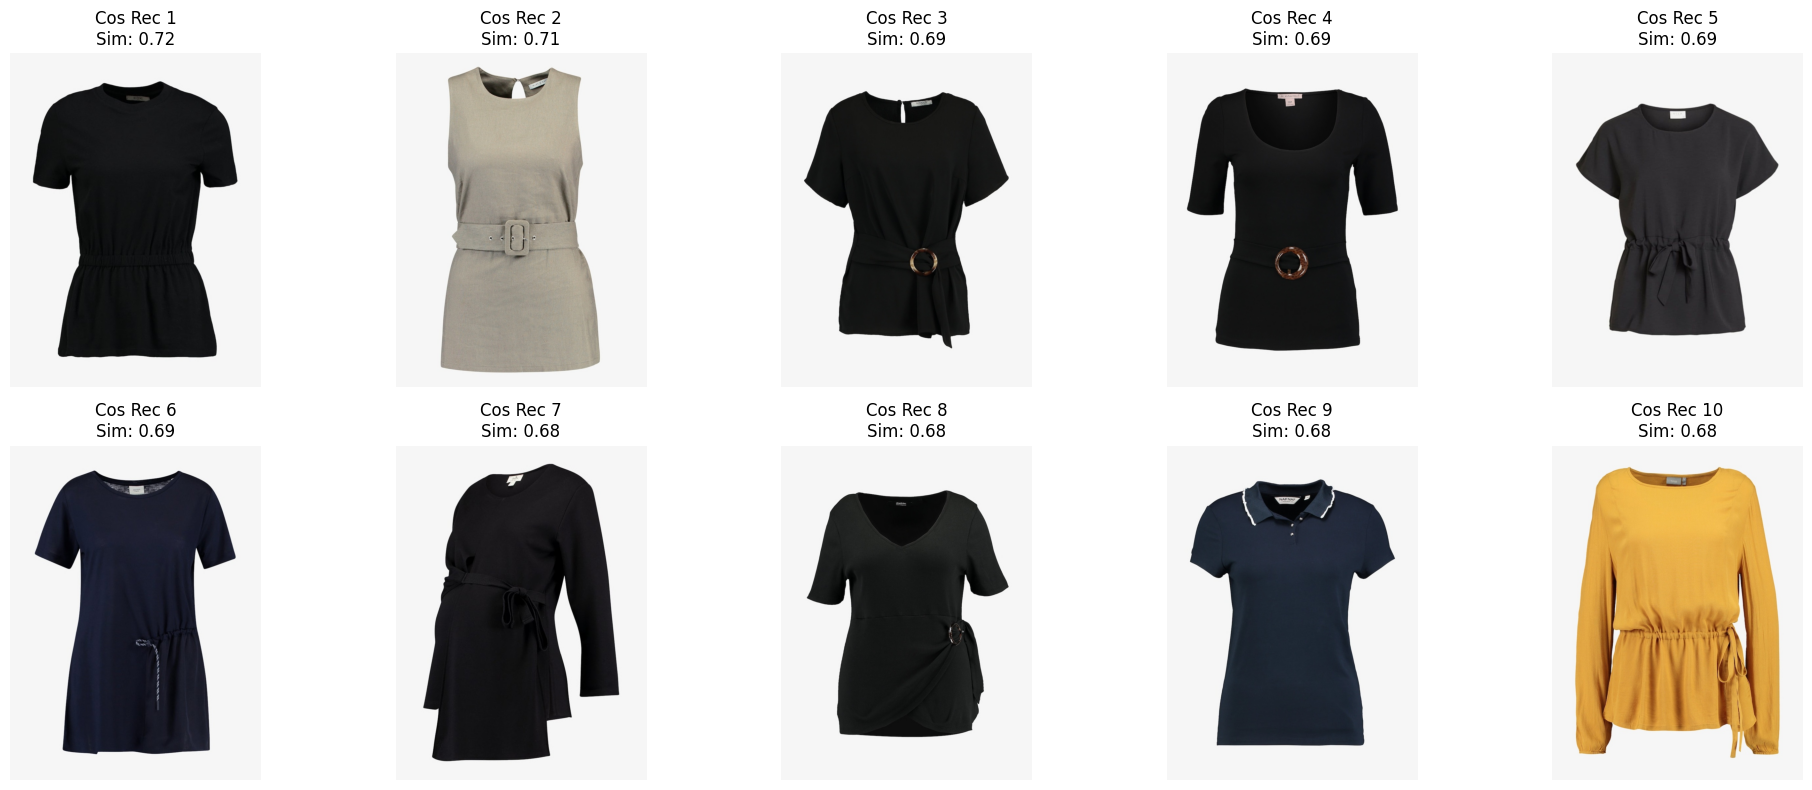


--- SCRIPT FINISHED ---


In [17]:
print("Loading feature database for recommendation...")
feature_list_path = os.path.join(OUTPUT_PATH, 'embedding.pkl')
filenames_path = os.path.join(OUTPUT_PATH, 'filenames.pkl')

try:
    feature_list = np.array(pickle.load(open(feature_list_path, 'rb')))
    filenames = pickle.load(open(filenames_path, 'rb'))
    print(f"--> Database with {len(feature_list)} embeddings loaded.")
except Exception as e:
    print(f"!!! FATAL ERROR loading database files: {e}")
    raise

neighbors_euclidean = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
neighbors_euclidean.fit(feature_list)
print("--> Euclidean Recommender is ready.")

neighbors_cosine = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')
neighbors_cosine.fit(feature_list)
print("--> Cosine Recommender is ready.")

query_image_filename = '00001_00.jpg' 
query_image_path = os.path.join(QUERY_IMAGE_PATH_DIR, query_image_filename)
print(f"\n--- Running recommendation for: {query_image_filename} ---")

cropped_garment = segment_and_crop_garment(
    query_image_path, 
    segmentation_interpreter, 
    segmentation_input_details, 
    segmentation_output_details
)

if cropped_garment:
    print("1. Garment detected and cropped.")
    query_features = extract_features(cropped_garment, model_feature_extractor)
    
    if query_features is not None:
        print("2. Features extracted from cropped garment.")
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(Image.open(query_image_path)); axes[0].set_title("Original Query"); axes[0].axis('off')
        axes[1].imshow(cropped_garment); axes[1].set_title("Auto-Cropped Garment"); axes[1].axis('off')
        plt.suptitle("Query Analysis", fontsize=16); plt.show()
        
        distances_euc, indices_euc = neighbors_euclidean.kneighbors([query_features])
        print("\n" + "="*50)
        print("      RESULTS USING EUCLIDEAN DISTANCE (Top 10)")
        print("="*50)
        print("--> Lower distance is better.")
        for i in range(len(indices_euc[0])):
            rank = i + 1
            file_index = indices_euc[0][i]
            distance = distances_euc[0][i]
            file_code = os.path.basename(filenames[file_index])
            print(f"  Rank {rank:02d}: Euclidean Distance = {distance:.4f}, File Code = {file_code}")
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        for i, file_index in enumerate(indices_euc[0]):
            ax = axes[i]; recommended_image_path = filenames[file_index]
            ax.imshow(Image.open(recommended_image_path))
            ax.set_title(f"Euc Rec {i+1}\nDist: {distances_euc[0][i]:.2f}"); ax.axis('off')
        plt.tight_layout()
        plt.show()

        distances_cos, indices_cos = neighbors_cosine.kneighbors([query_features])
        print("\n" + "="*50)
        print("        RESULTS USING COSINE SIMILARITY (Top 10)")
        print("="*50)
        print("--> Higher similarity is better.")
        for i in range(len(indices_cos[0])):
            rank = i + 1
            file_index = indices_cos[0][i]
            similarity = 1 - distances_cos[0][i]
            file_code = os.path.basename(filenames[file_index])
            print(f"  Rank {rank:02d}: Cosine Similarity = {similarity:.4f}, File Code = {file_code}")
            
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        for i, file_index in enumerate(indices_cos[0]):
            ax = axes[i]; recommended_image_path = filenames[file_index]
            ax.imshow(Image.open(recommended_image_path))
            similarity = 1 - distances_cos[0][i]
            ax.set_title(f"Cos Rec {i+1}\nSim: {similarity:.2f}"); ax.axis('off')
        plt.tight_layout()
        plt.show()

    else:
        print("!!! FAILED: Could not extract features from the cropped garment.")
else:
    print("\n!!! FAILED: Could not detect a garment in the query image.")
    plt.imshow(Image.open(query_image_path)); plt.title("Original Query (Detection Failed)"); plt.axis('off'); plt.show()

print("\n--- SCRIPT FINISHED ---")